This is the notebook I used to train the fruit classifier. This is the second time, and using methods like transfer learning and weight decay I was able to increase the accuracy over the same validation set from ~90% to 91.5%. I will write markdown comments throughout the notebook to help explain what I did a bit.

I will discuss how I created and cleaned the data set in the ReadMe.md file, as I did this in a different notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy

In [3]:
bs = 32

Below are separate cells with all of the folder and file names of the fruits anf the image urls.
This could have been done with a list and a for loop, but I like to see the individual cells sometimes.

In [4]:
folder = 'Apple'
file = 'urls_apple.csv'

In [7]:
folder = 'Banana'
file = 'urls_banana.csv'

In [10]:
folder = 'Blackberry'
file = 'urls_blackberry.csv'

In [13]:
folder = 'Blueberry'
file = 'urls_blueberry.csv'

In [16]:
folder = 'Lemon'
file = 'urls_lemon.csv'

In [19]:
folder = 'Lime'
file = 'urls_lime.csv'

In [22]:
folder = 'Mango'
file = 'urls_mango.csv'

In [25]:
folder = 'Orange'
file = 'urls_orange.csv'

In [28]:
folder = 'Pear'
file = 'urls_pear.csv'

In [31]:
folder = 'Raspberry'
file = 'urls_raspberry.csv'

In [34]:
folder = 'Strawberry'
file = 'urls_strawberry.csv'

In [37]:
folder = 'Tomato'
file = 'urls_tomato.csv'

In [38]:
path = Path('data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [4]:
path = Path('data')

In [29]:
path.ls()

[WindowsPath('data/Apple'),
 WindowsPath('data/Banana'),
 WindowsPath('data/Blackberry'),
 WindowsPath('data/Blueberry'),
 WindowsPath('data/Lemon'),
 WindowsPath('data/Lime'),
 WindowsPath('data/Mango'),
 WindowsPath('data/Orange'),
 WindowsPath('data/Pear'),
 WindowsPath('data/Raspberry'),
 WindowsPath('data/Strawberry'),
 WindowsPath('data/Tomato')]

In [5]:
classes = ['Apple', 'Banana', 'Blackberry', 'Blueberry', 'Lemon','Lime', 'Mango', 'Orange', 'Pear', 'Raspberry', 'Strawberry', 'Tomato']

download_images is a fastai function. It downloads the image from each url file. I've limited the data set to 300 images per fruit.

In [39]:
download_images(path/file, dest, max_pics=300)

In [42]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Apple


Banana


Blackberry


Blueberry


Lemon


Lime


Mango


Orange


Pear


Raspberry


Strawberry


Tomato


Now I'll create the data bunch. cleaned.csv is a file that containes the folder and name for each image that was kept after I cleaned the data.

To take advantage of transfer learning, I decided to start by using image sizes of 128x128 pixels. Later on I will update the data bunch to use higher pixel resolutions.

I used fastai's get_transforms() function, which uses pre-set transformations. These transformations help create more data without adding more pictures to the data set, which will allow the model to generalize better. Some of these transformations include:
- Image flipping
- Rotations
- Zooming into the picture slightly


In [6]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2,
csv_labels='cleaned.csv', ds_tfms=get_transforms(), size=128,
bs=bs, num_workers=4).normalize(imagenet_stats)

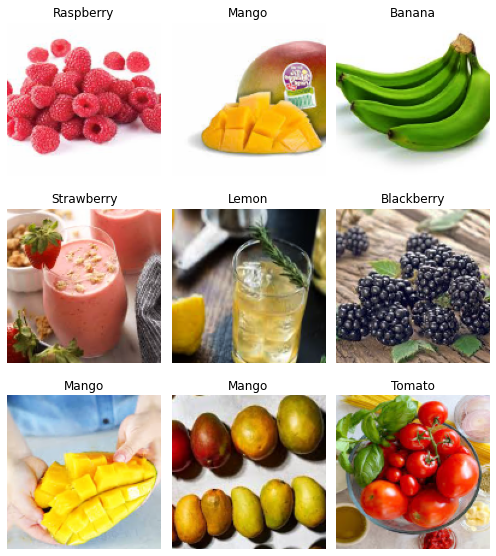

In [44]:
data.show_batch(rows=3, figsize=(7,8))

I found ResNet50 performed quite well when I was first experimenting, so I decided to stick with that model. It also allows me to compare the difference in accuracy after employing weight decay.

In [45]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\elipr/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.6MB/s]


fastai's lr_find() function plots losses compred to different learning rates. It helps find an at least decent learning rate right off the bat.

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


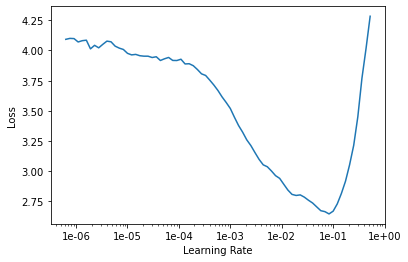

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(4, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.575162,0.824839,0.760417,01:17
1,1.010746,0.786807,0.793403,01:09
2,0.666526,0.605861,0.826389,01:11
3,0.439677,0.521442,0.852431,01:05


In [55]:
learn.save('stage-1')

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Once I added weight decay of wd=0.1, the model trained faster. It didn't necessarily achieve such different results at the moment though.

In [57]:
learn.fit_one_cycle(4, max_lr=3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.608378,1.034088,0.743056,00:48
1,1.011591,0.597631,0.814236,00:52
2,0.678626,0.513692,0.847222,00:50
3,0.477876,0.503653,0.850694,00:49


In [58]:
learn.save('stage-1 - wd=0.1')

When creating a learner in fastai, depending on the trained model you use, it will take off the last network layer from the model, and add on two extra arbitrary layers. The last layer added has the final output size of however many classes you have in the case of image classification. It then only trains those two layers by default, as the other layers have already been trained, and in ResNet50's case, for image classification. It kind of allows the two newly added layers to learn something about your images, or at least images in general.

When you call unfreeze(), it does just that. It unfreezes all the other layers, and when you train the model more, all the layers will be updated.

In [59]:
learn.unfreeze()

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


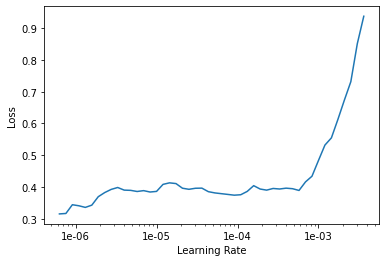

In [61]:
learn.recorder.plot()

fastai splits up the model's layers into 3 sections: the two added layers is one section, and the rest of the model gets split in half.

The slice() function can take in two values. The first value acts as the learning rate (lr) for the first section (if you think about it as columns of nodes, where between each colum is a layer, this would be the colums closest to the input), the second value is the lr for the last section (added two layers), and the middle section has an lr who's value is split in between.

I think fastai might also change the lr as the model goes through the epochs, but the above explanation is what I understand to happen.

In [62]:
learn.fit_one_cycle(4, max_lr=slice(2e-5, 1e-4), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.327343,0.490288,0.850694,01:11
1,0.351112,0.455535,0.873264,01:18
2,0.289604,0.406211,0.885417,01:20
3,0.224083,0.389577,0.887153,01:22


In [63]:
learn.save('stage-2 - wd=0.1')

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

It's always nice to take a look at what the model is messing up. Seems to be pretty decent accross the board.

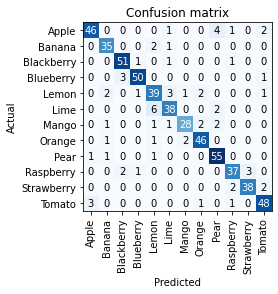

In [65]:
interp.plot_confusion_matrix()

In hindsight maybe I should have not frozen the model. Oh well.

In [9]:
learn.freeze()

I'm now making a new data bunch to employ transfer learning. The only change is the pixel resultion, which I've increased from 128x128 to 224x224. By doing this, I'm able to take advantage of faster training times per epoch while the model still learns things about the images. Then when I increase the pixel resolutions, it's like a whole new data set to the model which helps prevent overfitting, but it's already learned quite a bit about the fruits.

In [10]:
np.random.seed(42)
data1 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2,
csv_labels='cleaned.csv', ds_tfms=get_transforms(), size=224,
bs=bs, num_workers=4).normalize(imagenet_stats)

In [11]:
learn.data = data1

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


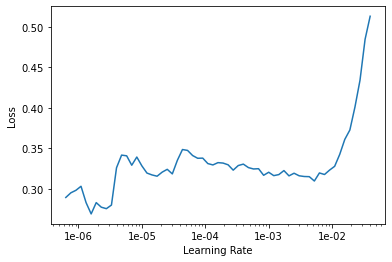

In [13]:
learn.recorder.plot()

The lower increase in accuracy from epoch to epoch might be because I froze the model right before creating the data bunch with 224x224 pixels. This is just a hypothesis though.

In [14]:
learn.fit_one_cycle(4, max_lr=slice(7e-5, 1e-3), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.313355,0.380902,0.888889,02:00
1,0.267041,0.367907,0.888889,01:57
2,0.208916,0.334564,0.895833,02:05
3,0.179880,0.325182,0.895833,02:07


In [15]:
interp = ClassificationInterpretation.from_learner(learn)

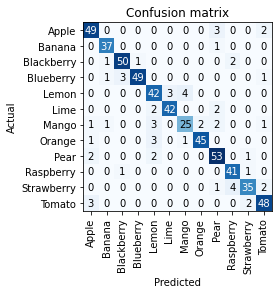

In [16]:
interp.plot_confusion_matrix()

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


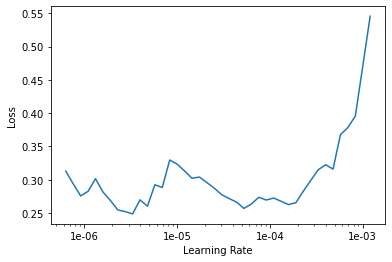

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(9e-6, 4e-4), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.423793,0.418882,0.869792,02:37
1,0.397656,0.419816,0.887153,02:46
2,0.290998,0.385765,0.902778,02:47
3,0.193837,0.351750,0.914931,02:49


In [16]:
learn.save('stage-4 - wd=0.1')

In [17]:
learn.fit_one_cycle(3, max_lr=slice(9e-6, 4e-4), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.203847,0.401585,0.890625,02:33
1,0.271570,0.404902,0.895833,02:45
2,0.156546,0.366530,0.902778,02:46


I wanted to see if increasing the pixel resolution once more could improve results. I cut the batch size in half due to GPU memory.

In [5]:
np.random.seed(42)
data3 = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2,
csv_labels='cleaned.csv', ds_tfms=get_transforms(), size=256,
bs=bs//2, num_workers=4).normalize(imagenet_stats)

The 'stage-4 - wd=0.1' model had higher accuracy with lower valid_loss relative to the 3 epochs I trained right after (just above), so I decided to use that.

In [ ]:
learn.load('stage-4 - wd=0.1')

In [20]:
learn.data = data3

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


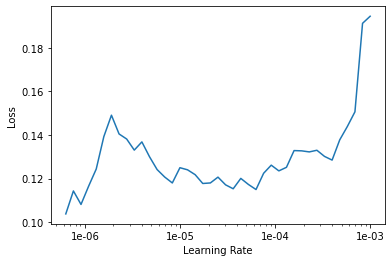

In [22]:
learn.recorder.plot()

The accuracy seemed to be jumping a bit, so I decided to use the 'stage-4 - wd=0.1' version of the model and end my training there. It's possible I could have gotten better results with a but more training, but I was happy with the 1.5% increase to 91.5% from the first I trained with this dataset. 

Next time I may try and start with pixel resolution of 64x64 and increase from there, either on this data set or another one.

In [24]:
learn.fit_one_cycle(4, max_lr=slice(2e-6, 5e-5), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.173297,0.365501,0.902778,02:43
1,0.167335,0.364486,0.899306,03:02
2,0.166465,0.333082,0.909722,03:10
3,0.113474,0.337870,0.904514,03:09


In [6]:
learn = cnn_learner(data3, models.resnet50, metrics=accuracy)

In [ ]:
learn.load('stage-4 - wd=0.1')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

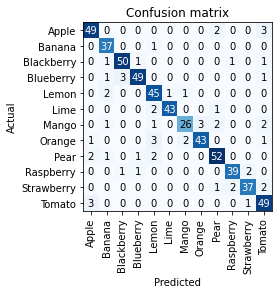

In [9]:
interp.plot_confusion_matrix()

In [11]:
interp.most_confused()

[('Apple', 'Tomato', 3),
 ('Blueberry', 'Blackberry', 3),
 ('Mango', 'Orange', 3),
 ('Orange', 'Lemon', 3),
 ('Tomato', 'Apple', 3),
 ('Apple', 'Pear', 2),
 ('Lemon', 'Banana', 2),
 ('Lime', 'Lemon', 2),
 ('Mango', 'Pear', 2),
 ('Mango', 'Tomato', 2),
 ('Orange', 'Mango', 2),
 ('Pear', 'Apple', 2),
 ('Pear', 'Lemon', 2),
 ('Raspberry', 'Strawberry', 2),
 ('Strawberry', 'Raspberry', 2),
 ('Strawberry', 'Tomato', 2),
 ('Banana', 'Lemon', 1),
 ('Blackberry', 'Banana', 1),
 ('Blackberry', 'Blueberry', 1),
 ('Blackberry', 'Raspberry', 1),
 ('Blackberry', 'Tomato', 1),
 ('Blueberry', 'Banana', 1),
 ('Blueberry', 'Tomato', 1),
 ('Lemon', 'Lime', 1),
 ('Lemon', 'Mango', 1),
 ('Lime', 'Pear', 1),
 ('Mango', 'Banana', 1),
 ('Mango', 'Lemon', 1),
 ('Orange', 'Apple', 1),
 ('Orange', 'Tomato', 1),
 ('Pear', 'Banana', 1),
 ('Pear', 'Blueberry', 1),
 ('Raspberry', 'Blackberry', 1),
 ('Raspberry', 'Blueberry', 1),
 ('Strawberry', 'Pear', 1),
 ('Tomato', 'Strawberry', 1)]

In [26]:
learn.export()